In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from datetime import datetime
import os
import sys
from glob import glob
from jupyterthemes import jtplot
from utils import plot_confusion_matrix
jtplot.style(theme='monokai', context='notebook', ticks=True)

In [3]:
# Load the datasets
train_data = torchvision.datasets.CIFAR10('.', train=True, 
                                          transform=transforms.ToTensor(), 
                                          download=True)


test_data = torchvision.datasets.CIFAR10('.', train=False,
                                        transform=transforms.ToTensor(),
                                        download=True)


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [5]:
batch_size=128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=False)

In [26]:
# Create the CNN model
class CNN(nn.Module):
    
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        
        self.cnn = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=2),
                nn.ReLU())
        
        self.dense = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(128*3*3, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, n_classes))
        
    
    def forward(self, X):
        X = self.cnn(X)
        X = X.view(-1, 128*3*3)
        X = self.dense(X)
        
        return X

In [27]:
n_classes = len(set(train_data.targets))
model = CNN(n_classes)

In [28]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [29]:
# Define Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [30]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    
    """
    ------------------------------------------------
    Description : Computes the batch gradient descent
                  on the data based on the given model
                  
    
    Parameters:
    model -- a pytorch model
    criterion -- a pytorch loss function
    optimizer -- a pytorch optimizer 
    train_loader -- a pytorch data loader representing train data
    test_loader -- a pytorch data loader representing test data
    epochs -- an integer representing the number of epochs
    
    
    Return:
    train_losses -- a numpy array representing overall losses (training)
    test_losses -- a numpy array representing overall losses(testing)
    
    Usage :
    train_loss, test_loss = batch_gd(model, criterion, optimizer, train_loader,
                                    test_loader, epochs=100)
    ---------------------------------------------------
    """
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        t0 = datetime.now()
        
        train_loss = []
        for inputs, targets in train_loader:
            
            # Transfer data to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Intialize zero-grad for the optimizer
            optimizer.zero_grad()
            
            # Forward prop
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            #Backward and optimize
            loss.backward()
            optimizer.step()
            
            # Track the loss 
            train_loss.append(loss.item())
            
        
        test_loss = []
        for inputs, targets in test_loader:
            
            # Transfer the target to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track the loss
            test_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        test_loss = np.mean(test_loss)
        
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
        print("Epoch : {}/{} | Train Loss : {:.4f} | Test Loss : {:.4f} | Time : {}".format(epoch+1, epochs,
                                                                                           train_loss, 
                                                                                           test_loss,
                                                                                           datetime.now()-t0))
        
    return train_losses, test_losses
            

In [31]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader,
                                    test_loader, epochs=20)


Epoch : 1/20 | Train Loss : 1.7330 | Test Loss : 1.5057 | Time : 0:00:08.692161
Epoch : 2/20 | Train Loss : 1.4326 | Test Loss : 1.3780 | Time : 0:00:08.560958
Epoch : 3/20 | Train Loss : 1.3111 | Test Loss : 1.2804 | Time : 0:00:08.635014
Epoch : 4/20 | Train Loss : 1.2304 | Test Loss : 1.2158 | Time : 0:00:08.564130
Epoch : 5/20 | Train Loss : 1.1657 | Test Loss : 1.1943 | Time : 0:00:08.611509
Epoch : 6/20 | Train Loss : 1.1044 | Test Loss : 1.1273 | Time : 0:00:08.546926
Epoch : 7/20 | Train Loss : 1.0570 | Test Loss : 1.1203 | Time : 0:00:08.564520
Epoch : 8/20 | Train Loss : 1.0198 | Test Loss : 1.0967 | Time : 0:00:08.476635
Epoch : 9/20 | Train Loss : 0.9802 | Test Loss : 1.0951 | Time : 0:00:08.565666
Epoch : 10/20 | Train Loss : 0.9505 | Test Loss : 1.0641 | Time : 0:00:08.560874
Epoch : 11/20 | Train Loss : 0.9165 | Test Loss : 1.0444 | Time : 0:00:08.579354
Epoch : 12/20 | Train Loss : 0.8919 | Test Loss : 1.0362 | Time : 0:00:08.662386
Epoch : 13/20 | Train Loss : 0.8580 |

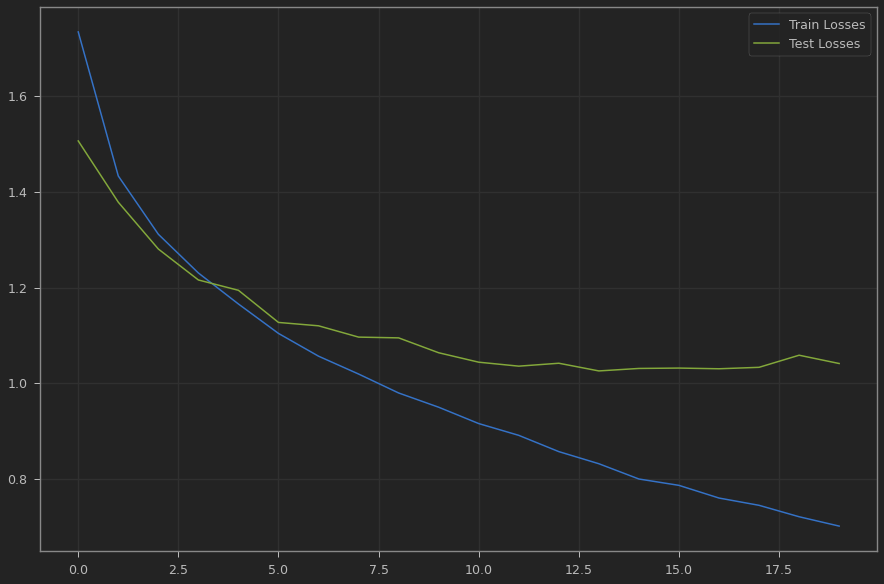

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Losses")
plt.plot(test_losses, label="Test Losses")
plt.legend()
plt.show()

In [36]:
def calculate_accuracy(loader):
    
    
    n_correct = 0
    n_total = 0

    for inputs, targets in train_loader:

        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
        
    
    return n_correct / n_total


train_acc = calculate_accuracy(train_loader)
test_acc = calculate_accuracy(test_loader)

print("Train accuracy : {:.4f} || Test accuracy : {:.4f}".format(train_acc,
                                                                test_acc))

Train accuracy : 0.7677 || Test accuracy : 0.7659


Confusion matrix, without normalization
[[710  15  52  30  20   6  12  15  86  54]
 [ 29 765   5  10   2   5   9   8  41 126]
 [ 66   7 514 105 113  69  55  37  17  17]
 [ 24   9  71 515  64 178  56  38  19  26]
 [ 18   6 108  87 559  47  58 100  15   2]
 [ 14   3  65 226  42 524  22  71  18  15]
 [  9   8  48 105  59  35 707   7   9  13]
 [ 16   4  40  57  62  71   7 706   9  28]
 [100  41  22  19  11   5   7   8 763  24]
 [ 44 112  12  25   9   6   7  19  44 722]]


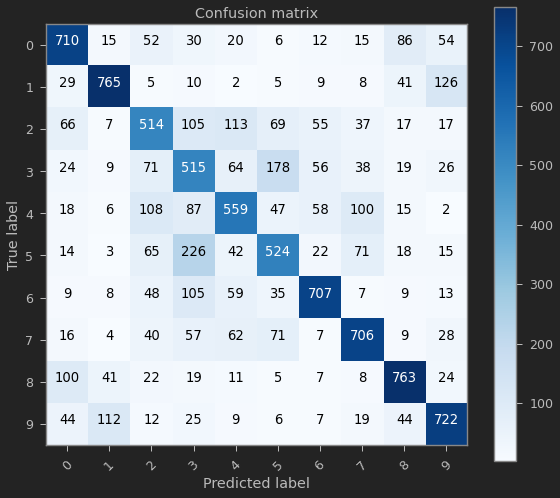

In [38]:
from sklearn.metrics import confusion_matrix
import itertools

x_test = test_data.data
y_test = np.array(test_data.targets)
p_test = np.array([])

for inputs, targets in test_loader:
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
plt.grid(b=False)
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(n_classes)))
    

In [39]:
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split('\n')

Text(0.5, 1.0, 'Original Label airplane || Predicted label : frog')

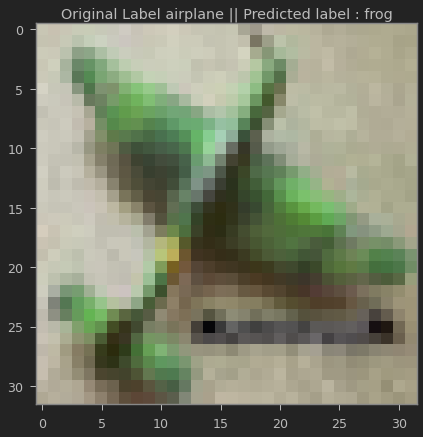

In [49]:
# Some of the misclassified examples
plt.grid(b=False)
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32, 32, 3))
plt.title("Original Label {} || Predicted label : {}".format(labels[y_test[i]], labels[p_test[i]]))